# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statitsics as `gender-stats.csv` using DataFusion.  Let's load those:

In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv')
link_stats.head()

,dataset,gender,n_books,n_actions
0,BX-E,male,57698,181903
1,BX-E,no-author-rec,5287,6687
2,BX-E,no-book,20075,23084
3,BX-I,unknown,32412,71413
4,BX-I,female,69805,399085


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:

In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book,total
dataset,,,,,,,,
AZ,239445.0,536254.0,22177.0,238663.0,126833.0,113652.0,985503.0,2262527.0
BX-E,39605.0,57698.0,5156.0,15741.0,5287.0,5613.0,20075.0,149175.0
BX-I,69805.0,100925.0,8840.0,32412.0,10644.0,11350.0,40633.0,274609.0
GR-E,215692.0,319920.0,16749.0,102653.0,42803.0,787097.0,NaN,1484914.0
GR-I,217786.0,323927.0,16921.0,104424.0,43624.0,799783.0,NaN,1506465.0
LOC-MDS,739026.0,2414466.0,70582.0,1136694.0,264367.0,609387.0,NaN,5234522.0


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,4781575.0,6913832.0,800290.0,2087337.0,780486.0,1278813.0,5798466.0
BX-E,141587.0,181903.0,41084.0,25250.0,6687.0,7614.0,23084.0
BX-I,399085.0,461986.0,102783.0,71413.0,17280.0,20420.0,56245.0
GR-E,36563996.0,33398520.0,12630193.0,3590506.0,741494.0,12294989.0,NaN
GR-I,82916368.0,69999126.0,20850719.0,10084875.0,2416945.0,33273918.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.105831,0.237016,0.009802,0.105485,0.056058,0.050232,0.435576
BX-E,0.265494,0.386781,0.034563,0.105520,0.035442,0.037627,0.134573
BX-I,0.254198,0.367523,0.032191,0.118030,0.038761,0.041331,0.147967
GR-E,0.145256,0.215447,0.011279,0.069131,0.028825,0.530062,NaN
GR-I,0.144568,0.215025,0.011232,0.069317,0.028958,0.530900,NaN
LOC-MDS,0.141183,0.461258,0.013484,0.217153,0.050505,0.116417,NaN


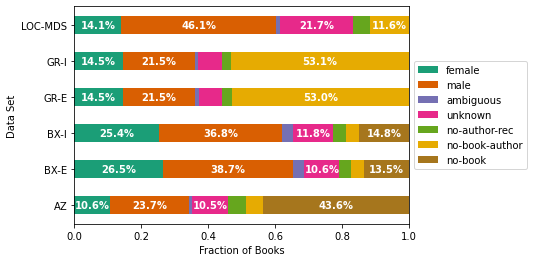

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.105831,0.237016,0.009802,0.105485,0.541867
BX-E,0.265494,0.386781,0.034563,0.105520,0.207642
BX-I,0.254198,0.367523,0.032191,0.118030,0.228059
GR-E,0.145256,0.215447,0.011279,0.069131,0.558888
GR-I,0.144568,0.215025,0.011232,0.069317,0.559858
LOC-MDS,0.141183,0.461258,0.013484,0.217153,0.166921


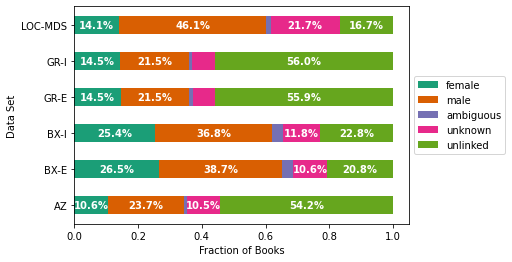

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

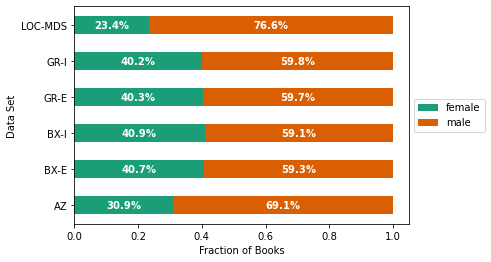

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.213075,0.308092,0.035662,0.093015,0.034780,0.056986,0.258389
BX-E,0.331423,0.425794,0.096168,0.059105,0.015653,0.017823,0.054034
BX-I,0.353419,0.409122,0.091022,0.063241,0.015303,0.018083,0.049809
GR-E,0.368515,0.336612,0.127295,0.036187,0.007473,0.123917,NaN
GR-I,0.377679,0.318842,0.094974,0.045936,0.011009,0.151561,NaN


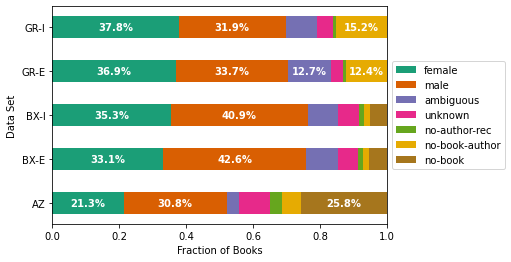

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.213075,0.308092,0.035662,0.093015,0.350155
BX-E,0.331423,0.425794,0.096168,0.059105,0.087510
BX-I,0.353419,0.409122,0.091022,0.063241,0.083195
GR-E,0.368515,0.336612,0.127295,0.036187,0.131390
GR-I,0.377679,0.318842,0.094974,0.045936,0.162570


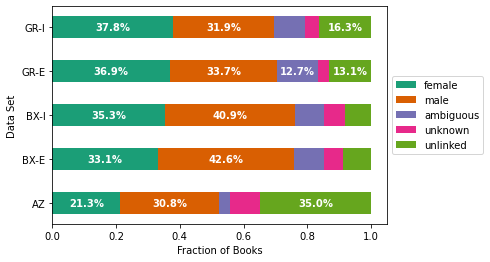

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

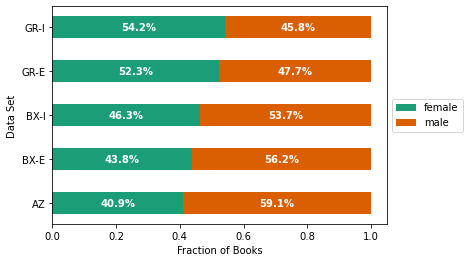

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))

## Metrics

Finally, we're going to write coverage metrics.

In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts['male'] + book_counts['female'] + book_counts['ambiguous']
book_cover = book_link / book_tots
book_cover

dataset
AZ         0.352648
BX-E       0.686838
BX-I       0.653912
GR-E       0.371982
GR-I       0.370824
LOC-MDS    0.615925
dtype: float64

In [21]:
book_cover.to_json('book-coverage.json')